In [1]:
# Import the libraries first!

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import json
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

! pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans

import folium 

print('Libraries imported.')

Libraries imported.


In [4]:
df_0=pd.read_csv('NYC_Dog_Licensing_Dataset.csv') 
print(df_0.head())
df_0.shape

   RowNumber AnimalName AnimalGender  AnimalBirthMonth  \
0          1      PAIGE            F              2014   
1          2       YOGI            M              2010   
2          3        ALI            M              2014   
3          4      QUEEN            F              2013   
4          5       LOLA            F              2009   

                              BreedName  Borough  ZipCode LicenseIssuedDate  \
0  American Pit Bull Mix / Pit Bull Mix      NaN    10035        09/12/2014   
1                                 Boxer      NaN    10465        09/12/2014   
2                               Basenji      NaN    10013        09/12/2014   
3                      Akita Crossbreed      NaN    10013        09/12/2014   
4                               Maltese      NaN    10028        09/12/2014   

  LicenseExpiredDate  Extract Year  
0         09/12/2017          2016  
1         10/02/2017          2016  
2         09/12/2019          2016  
3         09/12/2017        

(345727, 10)

In [6]:
df_nyczipcod=pd.read_csv('nyc_zip_borough_neighborhoods_pop.csv') 
df_nyczipcod.shape

(177, 6)

In [7]:
# Rename the "zip" column as "ZipCode"
df_nyczipcod.rename(columns={'zip':'ZipCode'}, inplace=True)

In [8]:
# Merging the dogs dataset and the neighborhood dataset
df_merged = pd.merge(df_0, df_nyczipcod, on=["ZipCode"]) 
df_merged.shape

(342394, 15)

In [9]:
df_merged.head(5)

RowNumber  AnimalName AnimalGender  AnimalBirthMonth  \
0          1       PAIGE            F              2014   
1         82       BRODY            M              2006   
2        199       ROCKO            M              2013   
3        282   SENSATION            F              2014   
4        290  TEMPTATION            M              2014   

                              BreedName  Borough  ZipCode LicenseIssuedDate  \
0  American Pit Bull Mix / Pit Bull Mix      NaN    10035        09/12/2014   
1                        Cocker Spaniel      NaN    10035        09/16/2014   
2                             Chihuahua      NaN    10035        09/27/2014   
3                               Mastiff      NaN    10035        10/05/2014   
4                               Mastiff      NaN    10035        10/05/2014   

  LicenseExpiredDate  Extract Year    borough   post_office neighborhood  \
0         09/12/2017          2016  Manhattan  New York, NY  East Harlem   
1         09/16/2016          2016  Manhattan  New York, NY  East Harlem   
2         09/27/2017          2016  Manhattan  New York, NY  East Harlem   
3         10/05/2016          2016  Manhattan  New York, NY  East Harlem   
4         10/05/2016          2016  Manhattan  New York, NY  East Harlem   

   population  density  
0       33969    24329  
1       33969    24329  
2       33969    24329  
3       33969    24329  
4       33969    24329

In [10]:
# Drop the columns we don't need
df_merged_drop=df_merged.drop(['RowNumber','Borough','Extract Year','ZipCode','post_office','LicenseIssuedDate','density','population'],axis=1)

In [11]:
#Drop the rows where at least one element is missing
df_merged_drop2=df_merged_drop.dropna()
df_merged_drop2.shape

(341677, 7)

In [12]:
# Rename some columns
df_merged_clean = df_merged_drop2.rename(columns= {'AnimalName':'Dog_Name','AnimalGender':'Dog_Gender','AnimalBirthMonth':'Dog_BirthYear',
                                         'BreedName':'Breed_Name','borough':'Borough','neighborhood':'Neighborhood'})

In [13]:
# Remove rows based on the license expired date
df_merged_clean1 = df_merged_clean.drop(df_merged_drop2[df_merged_drop2['LicenseExpiredDate']<"02/07/2020"].index)
df_merged_clean1.shape

(311032, 7)

In [14]:
df_expired = pd.DataFrame(df_merged_clean1["LicenseExpiredDate"].str.split(',', expand=True).stack(), columns=["LicenseExpiredDate"])
df_expired1=df_expired.groupby(["LicenseExpiredDate"])["LicenseExpiredDate"].count()
df_expired1.head(20)

LicenseExpiredDate
02/07/2020     61
02/07/2021     10
02/07/2022     19
02/07/2023     10
02/08/2016     43
02/08/2017    146
02/08/2018    179
02/08/2019    142
02/08/2020     41
02/08/2021     25
02/08/2022     13
02/08/2023      4
02/09/2016     90
02/09/2017    215
02/09/2018    214
02/09/2019    202
02/09/2020     41
02/09/2021     35
02/09/2022      5
02/09/2023      6
Name: LicenseExpiredDate, dtype: int64

In [15]:
# Converting object to datetime format
df_merged_clean1['LicenseExpiredDate'] = pd.to_datetime(df_merged_clean1['LicenseExpiredDate'])

# Extract year, month, day. Assign all these date component to new column.
df_merged_clean1['LicenseExpiredyear'] = df_merged_clean1['LicenseExpiredDate'].dt.year
df_merged_clean1.head()

Dog_Name Dog_Gender  Dog_BirthYear                            Breed_Name  \
0       PAIGE          F           2014  American Pit Bull Mix / Pit Bull Mix   
1       BRODY          M           2006                        Cocker Spaniel   
2       ROCKO          M           2013                             Chihuahua   
3   SENSATION          F           2014                               Mastiff   
4  TEMPTATION          M           2014                               Mastiff   

  LicenseExpiredDate    Borough Neighborhood  LicenseExpiredyear  
0         2017-09-12  Manhattan  East Harlem                2017  
1         2016-09-16  Manhattan  East Harlem                2016  
2         2017-09-27  Manhattan  East Harlem                2017  
3         2016-10-05  Manhattan  East Harlem                2016  
4         2016-10-05  Manhattan  East Harlem                2016

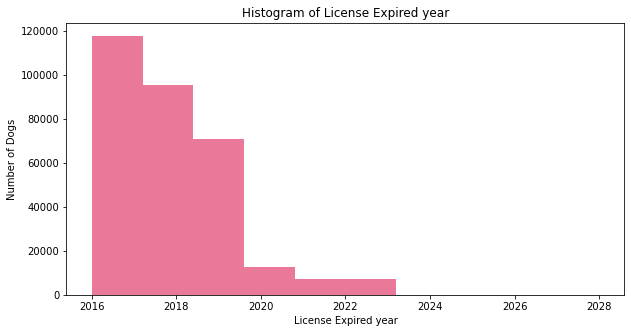

In [16]:
# Check out the distribution for "Dog_BirthYear" column
df_merged_clean1['LicenseExpiredyear'].plot(kind='hist', figsize=(10, 5), color='#ea7899')

plt.title('Histogram of License Expired year') # add a title
plt.ylabel('Number of Dogs') # add y-label
plt.xlabel('License Expired year') # add x-label

plt.show()

In [17]:
#Remove the rows where the license has expired.
df_merged_c = df_merged_clean1.drop(df_merged_clean1[df_merged_clean1['LicenseExpiredyear']<2020].index)  
df_merged_c.shape

(26994, 8)

In [18]:
# To see whether therea are any missing values
count = df_merged_c["LicenseExpiredDate"].isna().sum() 
print(count)

0


In [19]:
df_merged_c.head(5)

Dog_Name Dog_Gender  Dog_BirthYear                            Breed_Name  \
25    BEANS          M           2011                        Boston Terrier   
36     TALA          F           2009                               Unknown   
37   OLIVER          M           2005                               Unknown   
39   SHADOW          M           2013  American Pit Bull Mix / Pit Bull Mix   
46    SPOTS          M           2010                              Shih Tzu   

   LicenseExpiredDate    Borough Neighborhood  LicenseExpiredyear  
25         2020-03-17  Manhattan  East Harlem                2020  
36         2020-03-22  Manhattan  East Harlem                2020  
37         2020-03-22  Manhattan  East Harlem                2020  
39         2020-03-22  Manhattan  East Harlem                2020  
46         2020-05-24  Manhattan  East Harlem                2020

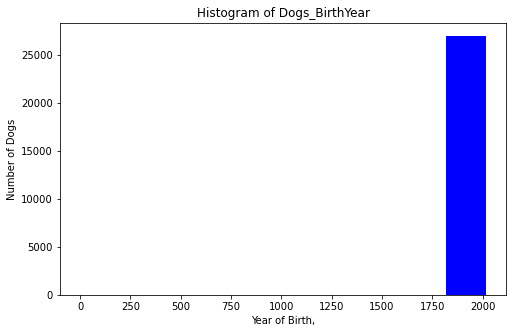

In [20]:
# Check out the distribution for "Dogs_BirthYear" column
df_merged_c['Dog_BirthYear'].plot(kind='hist', figsize=(8, 5), color='blue')

plt.title('Histogram of Dogs_BirthYear') # add a title
plt.ylabel('Number of Dogs') # add y-label
plt.xlabel('Year of Birth,') # add x-label

plt.show()

In [21]:
df_merged_c.describe()

Dog_BirthYear  LicenseExpiredyear
count   26994.000000        26994.000000
mean     2012.046529         2020.882307
std        24.399949            0.991893
min         1.000000         2020.000000
25%      2010.000000         2020.000000
50%      2013.000000         2021.000000
75%      2015.000000         2022.000000
max      2018.000000         2028.000000

In [22]:
# Remove rows in which dog live longer then 20 year average
df_merged_c1= df_merged_c.drop(df_merged_c[df_merged_c['Dog_BirthYear']<2000].index) 
df_merged_c1.shape

(26977, 8)

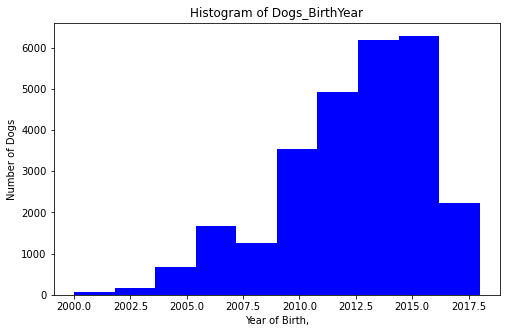

In [23]:
# Check out the distribution for "Dogs_BirthYear" column again!
df_merged_c1['Dog_BirthYear'].plot(kind='hist', figsize=(8, 5), color='blue')

plt.title('Histogram of Dogs_BirthYear') # add a title
plt.ylabel('Number of Dogs') # add y-label
plt.xlabel('Year of Birth,') # add x-label

plt.show()

In [24]:
df_merged_c1.head()

Dog_Name Dog_Gender  Dog_BirthYear                            Breed_Name  \
25    BEANS          M           2011                        Boston Terrier   
36     TALA          F           2009                               Unknown   
37   OLIVER          M           2005                               Unknown   
39   SHADOW          M           2013  American Pit Bull Mix / Pit Bull Mix   
46    SPOTS          M           2010                              Shih Tzu   

   LicenseExpiredDate    Borough Neighborhood  LicenseExpiredyear  
25         2020-03-17  Manhattan  East Harlem                2020  
36         2020-03-22  Manhattan  East Harlem                2020  
37         2020-03-22  Manhattan  East Harlem                2020  
39         2020-03-22  Manhattan  East Harlem                2020  
46         2020-05-24  Manhattan  East Harlem                2020

In [25]:
df_merged_c1.describe()

Dog_BirthYear  LicenseExpiredyear
count   26977.000000        26977.000000
mean     2012.398154         2020.882196
std         3.356734            0.991729
min      2000.000000         2020.000000
25%      2010.000000         2020.000000
50%      2013.000000         2021.000000
75%      2015.000000         2022.000000
max      2018.000000         2028.000000

In [26]:
# We convert the column into multiple rows
df_DogsName = pd.DataFrame(df_merged_c1["Dog_Name"].str.split(',', expand=True).stack(), columns=["Dog_Name"])
# We group and count each group
df_DogsName1=df_DogsName.groupby(["Dog_Name"])["Dog_Name"].count()
df_DogsName1.head(20)

Dog_Name
              4
AALSKA        3
AARON         1
ABBEY         6
ABBI          2
ABBIE         6
ABBY         39
ABEL          3
ABIGAIL       6
ABRAHAM       4
ABRIK         1
ABU           3
ACE          37
ACER          1
ACHILLES      6
ACHILLIES     1
ACKEES        1
ACTION        2
ADA           5
ADAR          1
Name: Dog_Name, dtype: int64

In [27]:
# We remove error names
df_DogsName2=df_DogsName1.drop(['','NAME NOT PROVIDED','UNKNOWN','NAME'],axis=0)

In [28]:
# Use to_frame to convert the series to DataFrame.
df_DogsName3 = df_DogsName2.to_frame()

In [29]:
df_DogsName3.shape # These are dogs registered with its name

(4854, 1)

In [30]:
df_DogsName3.head()

Dog_Name
Dog_Name          
AALSKA           3
AARON            1
ABBEY            6
ABBI             2
ABBIE            6

In [31]:
# We need to rename the column Dogs_Name to Ndogs (Number of dogs)
df_DogsName4 = df_DogsName3.rename(columns= {'Dog_Name': 'N_dogs'})

# sort dataframe on 'Pets Population' column (ascending)
df_DogsName4.sort_values(by='N_dogs', ascending=True, inplace=True)

# get a dataframe sort to know the top 10 of dog's names
df_DogsName5 = df_DogsName4['N_dogs'].tail(10)
df_DogsName6 = df_DogsName5.to_frame()
df_DogsName6.head(10)

N_dogs
Dog_Name        
DAISY        153
ROCKY        169
BAILEY       177
LUNA         182
LUCY         190
LOLA         200
COCO         210
CHARLIE      219
MAX          291
BELLA        313

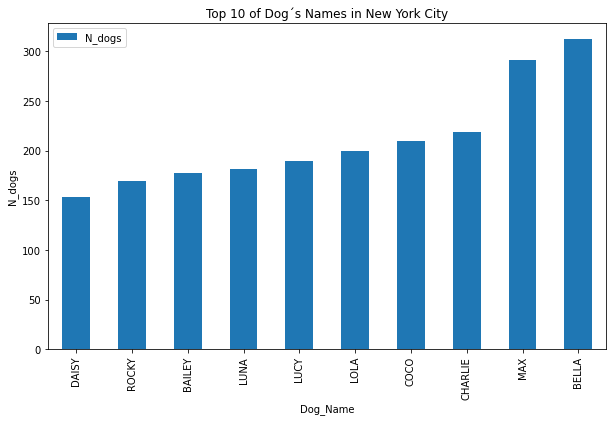

In [32]:
df_DogsName6.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Dog_Name') # add to x-label to the plot
plt.ylabel('N_dogs') # add y-label to the plot
plt.title('Top 10 of Dog´s Names in New York City') # add title to the plot

plt.show()

In [33]:
# We convert the column into multiple rows
df_gender = pd.DataFrame(df_merged_c1["Dog_Gender"].str.split(',', expand=True).stack(), columns=["Dog_Gender"])
# We group and count each group
df_gender1=df_gender.groupby(["Dog_Gender"])["Dog_Gender"].count()
df_gender1

Dog_Gender
F    12577
M    14400
Name: Dog_Gender, dtype: int64

In [34]:
# We convert the column into multiple rows
df_Breed = pd.DataFrame(df_merged_c1["Breed_Name"].str.split(',', expand=True).stack(), columns=["Breed_Name"])
# We group and count each group
df_Breed1=df_Breed.groupby(["Breed_Name"])["Breed_Name"].count()
df_Breed1.head()

Breed_Name
 American         16
 Bearded           5
 Black and Tan    20
 Blue Tick         6
 Border           41
Name: Breed_Name, dtype: int64

In [35]:
# Use to_frame to convert the series to DataFrame.
df_Breed2 = df_Breed1.to_frame()
# We need to rename the column Breed_Name to Ndogs (Number of dogs)
df_Breed3 = df_Breed2.rename(columns= {'Breed_Name': 'N_dogs'})

In [36]:
# sort dataframe on 'N_dogs' column (ascending)
df_Breed3.sort_values(by='N_dogs', ascending=True, inplace=True)

# Remove the "Unknown" data
df_Breed4=df_Breed3.drop(['Unknown'],axis=0) 

# get a dataframe sort to know top 10 Dog Breeds in New York
df_Breed5 = df_Breed4['N_dogs'].tail(10)
df_Breed6 = df_Breed5.to_frame()
df_Breed6.head(10)

N_dogs
Breed_Name                                  
Havanese                                 517
American Pit Bull Terrier/Pit Bull       534
American Pit Bull Mix / Pit Bull Mix     736
Maltese                                  748
Labrador Retriever Crossbreed            842
Poodle                                  1000
Labrador Retriever                      1087
Chihuahua                               1140
Shih Tzu                                1236
Yorkshire Terrier                       1239

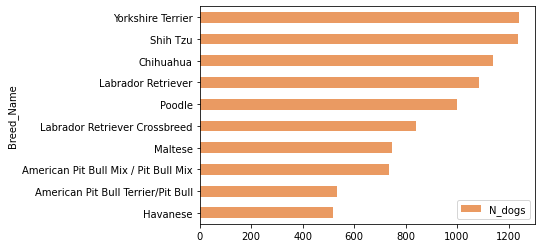

In [37]:
# Plot the top 10 Dog Breeds in New York
ax =df_Breed6.plot.barh(color={'#ea9a62'})

In [38]:
df_merged_c1['Borough'].unique() #Where we can find dogs in NY

array(['Manhattan', 'Bronx', 'Brooklyn', 'Staten Island', 'Queens'],
      dtype=object)

In [39]:
df_merged_c1['Neighborhood'].unique()

array(['East Harlem', 'Southeast Bronx', 'Greenwich Village and Soho',
       'Upper East Side', 'Upper West Side', 'Northwest Brooklyn',
       'Gramercy Park and Murray Hill', 'Lower East Side', 'Sunset Park',
       'Inwood and Washington Heights', 'Kingsbridge and Riverdale',
       'Central Brooklyn', 'South Shore', 'Chelsea and Clinton',
       'Southwest Brooklyn', 'East New York and New Lots', 'Borough Park',
       'Southern Brooklyn', 'Canarsie and Flatlands', 'Northeast Queens',
       'Lower Manhattan', 'Bronx Park and Fordham', 'Northwest Queens',
       'West Central Queens', 'High Bridge and Morrisania', 'Jamaica',
       'Northeast Bronx', 'Central Bronx', 'Greenpoint',
       'Hunts Point and Mott Haven', 'West Queens',
       'Bushwick and Williamsburg', 'Central Harlem',
       'Stapleton and St. George', 'Mid-Island', 'Central Queens',
       'Rockaways', 'North Queens', 'Southwest Queens',
       'Southeast Queens', 'Flatbush', 'Tribeca', 'Port Richmond',
       'L

In [40]:
print('The dataframe has {} boroughs and {} neighborhoods'.format(
        len(df_merged_c['Borough'].unique()),
        len(df_merged_c['Neighborhood'].unique())
    )
)

The dataframe has 5 boroughs and 45 neighborhoods


In [41]:
# We convert the column into multiple rows
df_Neighborhood = pd.DataFrame(df_merged_c1["Neighborhood"].str.split(',', expand=True).stack(), columns=["Neighborhood"])
# We group and count each group
df_Neighborhood1=df_Neighborhood.groupby(["Neighborhood"])["Neighborhood"].count()
df_Neighborhood1.head(20)

Neighborhood
Borough Park                      514
Bronx Park and Fordham            213
Bushwick and Williamsburg         563
Canarsie and Flatlands            280
Central Bronx                     139
Central Brooklyn                  718
Central Harlem                    516
Central Queens                    228
Chelsea and Clinton              1815
East Harlem                       519
East New York and New Lots        150
Flatbush                          343
Gramercy Park and Murray Hill    1147
Greenpoint                        478
Greenwich Village and Soho        951
High Bridge and Morrisania        200
Hunts Point and Mott Haven        186
Inwood and Washington Heights     712
Jamaica                           281
Kingsbridge and Riverdale         286
Name: Neighborhood, dtype: int64

In [42]:
# Use to_frame to convert the series to DataFrame.
df_Neighborhood2 = df_Neighborhood1.to_frame()

# We need to rename the column Breed_Name to Ndogs (Number of dogs)
df_Neighborhood3 = df_Neighborhood2.rename(columns= {'Neighborhood': 'N_dogs'})

In [43]:
# sort dataframe on 'N_dogs' column (ascending)
df_Neighborhood3.sort_values(by='N_dogs', ascending=True, inplace=True)

# get a dataframe sort to know top 10 pet lover neighborhood
df_Neighborhood4 = df_Neighborhood3['N_dogs'].tail(10)
df_Neighborhood5 = df_Neighborhood4.to_frame()
df_Neighborhood5.head(10)

N_dogs
Neighborhood                         
South Shore                       795
Northwest Queens                  902
West Queens                       932
Greenwich Village and Soho        951
Gramercy Park and Murray Hill    1147
Lower East Side                  1342
Chelsea and Clinton              1815
Upper East Side                  1916
Upper West Side                  2045
Northwest Brooklyn               2100

In [44]:
# When we reset the index, the old index is added as a column, and a new sequential index is used
df_Neighborhood6=df_Neighborhood5.reset_index()
df_Neighborhood6.head(20)

Neighborhood  N_dogs
0                    South Shore     795
1               Northwest Queens     902
2                    West Queens     932
3     Greenwich Village and Soho     951
4  Gramercy Park and Murray Hill    1147
5                Lower East Side    1342
6            Chelsea and Clinton    1815
7                Upper East Side    1916
8                Upper West Side    2045
9             Northwest Brooklyn    2100

In [45]:
df_Neighborhood7 = pd.merge(df_Neighborhood6, df_merged_c1, on=["Neighborhood"]) # Merge both datasets
df_Neighborhood7.shape

(13945, 9)

In [46]:
df_Neighborhood8=df_Neighborhood7.drop_duplicates(['N_dogs']) #Remove duplicate data in 'N_dogs' column
# Remove some columns we do not need.
df_Neighborhood9=df_Neighborhood8.drop(['Dog_Name','Dog_Gender','Dog_BirthYear','Breed_Name','LicenseExpiredDate','LicenseExpiredyear'],axis=1)

In [47]:
df_Neighborhood9.head(20)

Neighborhood  N_dogs        Borough
0                        South Shore     795  Staten Island
795                 Northwest Queens     902         Queens
1697                     West Queens     932         Queens
2629      Greenwich Village and Soho     951      Manhattan
3580   Gramercy Park and Murray Hill    1147      Manhattan
4727                 Lower East Side    1342      Manhattan
6069             Chelsea and Clinton    1815      Manhattan
7884                 Upper East Side    1916      Manhattan
9800                 Upper West Side    2045      Manhattan
11845             Northwest Brooklyn    2100       Brooklyn

In [48]:
# We convert the column into multiple rows
df_borough = pd.DataFrame(df_merged_c1["Borough"].str.split(',', expand=True).stack(), columns=["Borough"])
# We group and count each group
df_borough1=df_borough.groupby(["Borough"])["Borough"].count()
df_borough1.head()

Borough
Bronx             2017
Brooklyn          6451
Manhattan        11660
Queens            5129
Staten Island     1720
Name: Borough, dtype: int64

In [49]:
# convert the series to DataFrame.
df_borough2 = df_borough1.to_frame()

# We need to rename the column borough to Ndogs (Number of dogs)
df_borough3 = df_borough2.rename(columns= {'Borough': 'N_dogs'})

In [50]:
# sort dataframe on 'N_dogs' column (ascending)
df_borough3.sort_values(by='N_dogs', ascending=True, inplace=True)

# get a dataframe sort to know top 10 pet lover neighborhood
df_borough4 = df_borough3['N_dogs'].tail(10)
df_borough5 = df_borough4.to_frame()
df_borough5.head()

N_dogs
Borough              
Staten Island    1720
Bronx            2017
Queens           5129
Brooklyn         6451
Manhattan       11660

In [51]:
# When we reset the index, the old index is added as a column, and a new sequential index is used
df_borough6=df_borough5.reset_index()

In [52]:
# We need to rename the column borough
df_borough7 = df_borough6.rename(columns= {'Borough': 'borough'})
df_borough7.head()

borough  N_dogs
0  Staten Island    1720
1          Bronx    2017
2         Queens    5129
3       Brooklyn    6451
4      Manhattan   11660

In [54]:
# loading the data.
with open('Borough Boundaries.geojson') as json_data:
    Borough_geo = json.load(json_data)

In [55]:
Borough_data = Borough_geo['features']

In [56]:
Borough_data[0]

{'type': 'Feature',
 'properties': {'boro_code': '2',
  'boro_name': 'Bronx',
  'shape_area': '1186612670.99',
  'shape_leng': '462958.559564'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-73.89680883223774, 40.79580844515979],
     [-73.89693872998792, 40.79563587285357],
     [-73.89723603843939, 40.79572003753707],
     [-73.89796839783742, 40.795644839161994],
     [-73.89857332665558, 40.7960691402596],
     [-73.89895261832527, 40.796227852579634],
     [-73.89919434249981, 40.79650245601822],
     [-73.89852052071471, 40.796936194189776],
     [-73.89788253240185, 40.79711653214705],
     [-73.89713149795642, 40.79679807772831],
     [-73.89678526341234, 40.796329166487105],
     [-73.89680883223774, 40.79580844515979]]],
   [[[-73.88885148496334, 40.798706328958765],
     [-73.88860021869873, 40.798650985918705],
     [-73.8885856250733, 40.798706072297094],
     [-73.88821348851279, 40.798665304638554],
     [-73.88821415282712, 40.79866379621751],
     [-73.88

In [57]:
# visualize Pet lover boroughs
Borough_geo = r'Borough Boundaries.geojson' 

# create a plain world map
NewYork_map1 = folium.Map(location=[40.6643,-73.9385], zoom_start=10)

# generate choropleth map
NewYork_map1.choropleth(
    geo_data=Borough_geo,
    data=df_borough7,
    columns=['borough','N_dogs'],
    key_on='feature.properties.boro_name',
    fill_color='RdPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Pet Lover Boroughs in NY'
)

# Show the map
NewYork_map1

In [58]:
# This is the dataframe to adapt in order to run K-Means algorithm
df_merged_c1.head()

Dog_Name Dog_Gender  Dog_BirthYear                            Breed_Name  \
25    BEANS          M           2011                        Boston Terrier   
36     TALA          F           2009                               Unknown   
37   OLIVER          M           2005                               Unknown   
39   SHADOW          M           2013  American Pit Bull Mix / Pit Bull Mix   
46    SPOTS          M           2010                              Shih Tzu   

   LicenseExpiredDate    Borough Neighborhood  LicenseExpiredyear  
25         2020-03-17  Manhattan  East Harlem                2020  
36         2020-03-22  Manhattan  East Harlem                2020  
37         2020-03-22  Manhattan  East Harlem                2020  
39         2020-03-22  Manhattan  East Harlem                2020  
46         2020-05-24  Manhattan  East Harlem                2020

In [59]:
# Remove some columns.
df_segmentation=df_merged_c1.drop(['LicenseExpiredDate','LicenseExpiredyear'],axis=1)

# When we reset the index, the old index is added as a column, and a new sequential index is used
df_segmentation1=df_segmentation.reset_index()

# Remove a column and see part of the dataset with the selected variables to run the model
df_segmentation2=df_segmentation1.drop(['index'],axis=1)
df_segmentation2.head(5)

Dog_Name Dog_Gender  Dog_BirthYear                            Breed_Name  \
0    BEANS          M           2011                        Boston Terrier   
1     TALA          F           2009                               Unknown   
2   OLIVER          M           2005                               Unknown   
3   SHADOW          M           2013  American Pit Bull Mix / Pit Bull Mix   
4    SPOTS          M           2010                              Shih Tzu   

     Borough Neighborhood  
0  Manhattan  East Harlem  
1  Manhattan  East Harlem  
2  Manhattan  East Harlem  
3  Manhattan  East Harlem  
4  Manhattan  East Harlem

In [60]:
df_segmentation3= pd.get_dummies(df_segmentation2, columns = ["Dog_Gender"], drop_first=True)
df_segmentation3.tail()

Dog_Name  Dog_BirthYear            Breed_Name Borough      Neighborhood  \
26972    PLUTO           2012            Cane Corso  Queens  Southeast Queens   
26973   REGGAE           2007               Unknown  Queens  Southeast Queens   
26974     COCO           2014  Chihuahua Crossbreed  Queens  Southeast Queens   
26975     BOZO           2015   German Shepherd Dog  Queens  Southeast Queens   
26976    FRITZ           2009   German Shepherd Dog  Queens  Southeast Queens   

       Dog_Gender_M  
26972             1  
26973             1  
26974             0  
26975             1  
26976             1

In [61]:
df_Breed0 = df_segmentation2.groupby('Breed_Name').count()
df_Breed0.head()

Dog_Name  Dog_Gender  Dog_BirthYear  Borough  \
Breed_Name                                                              
Affenpinscher                   8           8              8        8   
Afghan Hound                    5           5              5        5   
Afghan Hound Crossbreed         3           3              3        3   
Airedale Terrier               23          23             23       23   
Akita                          31          31             31       31   

                         Neighborhood  
Breed_Name                             
Affenpinscher                       8  
Afghan Hound                        5  
Afghan Hound Crossbreed             3  
Airedale Terrier                   23  
Akita                              31

In [62]:
# When we reset the index, the old index is added as a column, and a new sequential index is used
df_Breeddum=df_Breed0.reset_index()
df_Breeddum1=df_Breeddum.reset_index()
df_Breeddum1.tail()

index                    Breed_Name  Dog_Name  Dog_Gender  Dog_BirthYear  \
270    270   Wirehaired Pointing Griffon        12          12             12   
271    271             Wirehaired Vizsla         2           2              2   
272    272                Xoloitzcuintli         5           5              5   
273    273             Yorkshire Terrier      1239        1239           1239   
274    274  Yorkshire Terrier Crossbreed       223         223            223   

     Borough  Neighborhood  
270       12            12  
271        2             2  
272        5             5  
273     1239          1239  
274      223           223

In [63]:
# We need to rename the column 'index'
df_Breeddum2 = df_Breeddum1.rename(columns= {'index':'Breed_dum'})

In [64]:
# Remove a column.
df_Breeddum3=df_Breeddum2.drop(['Dog_Name','Dog_Gender','Dog_BirthYear','Borough','Neighborhood'],axis=1)
df_Breeddum3.tail(3)

Breed_dum                    Breed_Name
272        272                Xoloitzcuintli
273        273             Yorkshire Terrier
274        274  Yorkshire Terrier Crossbreed

In [65]:
df_segmentation4 = pd.merge(df_segmentation3, df_Breeddum3, on=["Breed_Name"]) # Merge both datasets
df_segmentation4.tail()

Dog_Name  Dog_BirthYear                           Breed_Name   Borough  \
26972    FABIO           2008                 Peruvian Inca Orchid  Brooklyn   
26973    FABIO           2008                 Peruvian Inca Orchid  Brooklyn   
26974    FABIO           2008                 Peruvian Inca Orchid  Brooklyn   
26975     DUKE           2010  Mastiff, French (Dogue de Bordeaux)    Queens   
26976    MONTY           2017                            Beauceron    Queens   

           Neighborhood  Dog_Gender_M  Breed_dum  
26972  Central Brooklyn             1        188  
26973  Central Brooklyn             1        188  
26974  Central Brooklyn             1        188  
26975  Southeast Queens             1        163  
26976      North Queens             1         30

In [66]:
df_BoroughDum = pd.DataFrame({'Borough_Dum': ['1','2','3','4','5'], 'Borough': ['Manhattan','Brooklyn','Queens','Bronx','Staten Island'],})
df_BoroughDum

Borough_Dum        Borough
0           1      Manhattan
1           2       Brooklyn
2           3         Queens
3           4          Bronx
4           5  Staten Island

In [67]:
df_segmentation5 = pd.merge(df_segmentation4, df_BoroughDum, on=["Borough"]) # Merge both datasets
df_segmentation5.tail()

Dog_Name  Dog_BirthYear                           Breed_Name Borough  \
26972    KEITH           2007                                 Puli  Queens   
26973     AMOL           2012                     Mastiff, Tibetan  Queens   
26974     AMOL           2012                     Mastiff, Tibetan  Queens   
26975     DUKE           2010  Mastiff, French (Dogue de Bordeaux)  Queens   
26976    MONTY           2017                            Beauceron  Queens   

           Neighborhood  Dog_Gender_M  Breed_dum Borough_Dum  
26972         Rockaways             1        208           3  
26973      North Queens             1        166           3  
26974      North Queens             1        166           3  
26975  Southeast Queens             1        163           3  
26976      North Queens             1         30           3

In [68]:
df_neighborhoodDum = df_segmentation2.groupby('Neighborhood').count()
df_neighborhoodDum.head()

Dog_Name  Dog_Gender  Dog_BirthYear  Breed_Name  \
Neighborhood                                                                 
Borough Park                    514         514            514         514   
Bronx Park and Fordham          213         213            213         213   
Bushwick and Williamsburg       563         563            563         563   
Canarsie and Flatlands          280         280            280         280   
Central Bronx                   139         139            139         139   

                           Borough  
Neighborhood                        
Borough Park                   514  
Bronx Park and Fordham         213  
Bushwick and Williamsburg      563  
Canarsie and Flatlands         280  
Central Bronx                  139

In [69]:
# When we reset the index, the old index is added as a column, and a new sequential index is used
df_neighborhoodDum1=df_neighborhoodDum.reset_index()
df_neighborhoodDum2=df_neighborhoodDum1.reset_index()
df_neighborhoodDum2.tail()

index         Neighborhood  Dog_Name  Dog_Gender  Dog_BirthYear  \
40     40      Upper East Side      1916        1916           1916   
41     41      Upper West Side      2045        2045           2045   
42     42  West Central Queens       782         782            782   
43     43          West Queens       932         932            932   
44     44            West Side        71          71             71   

    Breed_Name  Borough  
40        1916     1916  
41        2045     2045  
42         782      782  
43         932      932  
44          71       71

In [70]:
# We need to rename the column 'index'
df_neighborhoodDum3 = df_neighborhoodDum2.rename(columns= {'index':'Neighborhood_dum'})
# Remove a column.
df_neighborhoodDum4=df_neighborhoodDum3.drop(['Dog_Name','Dog_Gender','Dog_BirthYear','Borough','Breed_Name'],axis=1)
df_neighborhoodDum4.tail(3)

Neighborhood_dum         Neighborhood
42                42  West Central Queens
43                43          West Queens
44                44            West Side

In [71]:
df_segmentation6 = pd.merge(df_segmentation5, df_neighborhoodDum4, on=["Neighborhood"]) # Merge both datasets
df_segmentation6.tail()

Dog_Name  Dog_BirthYear                           Breed_Name Borough  \
26972   GINGER           2012                   Collie, Rough Coat  Queens   
26973     DINO           2017          Soft Coated Wheaten Terrier  Queens   
26974     KATE           2014                              Chinook  Queens   
26975     KATE           2014                              Chinook  Queens   
26976     DUKE           2010  Mastiff, French (Dogue de Bordeaux)  Queens   

           Neighborhood  Dog_Gender_M  Breed_dum Borough_Dum  Neighborhood_dum  
26972  Southeast Queens             0         84           3                33  
26973  Southeast Queens             1        242           3                33  
26974  Southeast Queens             0         74           3                33  
26975  Southeast Queens             0         74           3                33  
26976  Southeast Queens             1        163           3                33

In [72]:
df_Dog_NameDum = df_segmentation2.groupby('Dog_Name').count()
df_Dog_NameDum.head()

Dog_Gender  Dog_BirthYear  Breed_Name  Borough  Neighborhood
Dog_Name                                                              
AALSKA             3              3           3        3             3
AARON              1              1           1        1             1
ABBEY              6              6           6        6             6
ABBI               2              2           2        2             2
ABBIE              6              6           6        6             6

In [73]:
# When we reset the index, the old index is added as a column, and a new sequential index is used
df_Dog_NameDum1=df_Dog_NameDum.reset_index()
df_Dog_NameDum2=df_Dog_NameDum1.reset_index()
df_Dog_NameDum2.tail()

index Dog_Name  Dog_Gender  Dog_BirthYear  Breed_Name  Borough  \
4854   4854    ZUMBA           2              2           2        2   
4855   4855     ZURI           6              6           6        6   
4856   4856     ZUSY           1              1           1        1   
4857   4857     ZUZU           3              3           3        3   
4858   4858    ÔISHI           3              3           3        3   

      Neighborhood  
4854             2  
4855             6  
4856             1  
4857             3  
4858             3

In [74]:
# We need to rename the column 'index'
df_Dog_NameDum3 = df_Dog_NameDum2.rename(columns= {'index':'Dog_NameDum'})

In [75]:
# Remove a column.
df_Dog_NameDum4=df_Dog_NameDum3.drop(['Breed_Name','Dog_Gender','Dog_BirthYear','Borough','Neighborhood'],axis=1)
df_Dog_NameDum4.tail(3)

Dog_NameDum Dog_Name
4856         4856     ZUSY
4857         4857     ZUZU
4858         4858    ÔISHI

In [76]:
df_segmentation7 = pd.merge(df_segmentation6, df_Dog_NameDum4, on=["Dog_Name"]) # Merge both datasets
df_segmentation7.tail()

Dog_Name  Dog_BirthYear            Breed_Name Borough      Neighborhood  \
26972     HYPE           2012           Poodle, Toy  Queens  Southeast Queens   
26973  HANDSOM           2013        Cocker Spaniel  Queens  Southeast Queens   
26974     LINK           2016  Dachshund Crossbreed  Queens  Southeast Queens   
26975     KATE           2014               Chinook  Queens  Southeast Queens   
26976     KATE           2014               Chinook  Queens  Southeast Queens   

       Dog_Gender_M  Breed_dum Borough_Dum  Neighborhood_dum  Dog_NameDum  
26972             1        203           3                33         1910  
26973             1         78           3                33         1777  
26974             1         93           3                33         2527  
26975             0         74           3                33         2215  
26976             0         74           3                33         2215

In [77]:
# Remove some columns.
df_segmentation8=df_segmentation7.drop(['Dog_Name','Breed_Name','Neighborhood','Borough'],axis=1)
df_segmentation8.head()

Dog_BirthYear  Dog_Gender_M  Breed_dum Borough_Dum  Neighborhood_dum  \
0           2011             1         49           1                 9   
1           2011             1         49           1                 9   
2           2011             1         49           1                 9   
3           2018             1        149           3                28   
4           2011             1         49           1                 9   

   Dog_NameDum  
0          322  
1          322  
2          322  
3          322  
4         1131

In [78]:
# We need to rename the columns 'ZipCode' and 'population'
df_segmentation9 = df_segmentation8.rename(columns= {'ZipCode':'ZipCode_Neighborhood','population':'Neighborhood_Population' })

In [79]:
# Filter dataframe by Manhattan
df_ManhattanSeg = df_segmentation8.drop(df_segmentation8[df_segmentation8['Borough_Dum']=='2'].index)  
df_ManhattanSeg1 = df_ManhattanSeg.drop(df_ManhattanSeg[df_ManhattanSeg['Borough_Dum']=='3'].index)  
df_ManhattanSeg2 = df_ManhattanSeg1.drop(df_ManhattanSeg1[df_ManhattanSeg1['Borough_Dum']=='4'].index) 
df_ManhattanSeg3= df_ManhattanSeg2.drop(df_ManhattanSeg2[df_ManhattanSeg2['Borough_Dum']=='5'].index) 
df_ManhattanSeg3.shape

(11660, 6)

In [80]:
# Remove the Borough_Dum column.
df_ManhattanSeg4=df_ManhattanSeg3.drop(['Borough_Dum'],axis=1)
df_ManhattanSeg4.head()

Dog_BirthYear  Dog_Gender_M  Breed_dum  Neighborhood_dum  Dog_NameDum
0           2011             1         49                 9          322
1           2011             1         49                 9          322
2           2011             1         49                 9          322
4           2011             1         49                 9         1131
5           2011             1         49                 9         1131

In [81]:
# export the dataframe
df_ManhattanSeg4.to_csv('Manhattan_dummies.csv')

In [82]:
#Normalizing over the standard deviation.
from sklearn.preprocessing import StandardScaler
X = df_ManhattanSeg4.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.93471619, -1.30495598, -1.02618324, -1.53329537],
       [ 0.93471619, -1.30495598, -1.02618324, -1.53329537],
       [ 0.93471619, -1.30495598, -1.02618324, -1.53329537],
       ...,
       [ 0.93471619,  0.66233521,  1.53754727,  1.66107295],
       [ 0.93471619, -0.2960887 ,  1.53754727, -0.76113466],
       [ 0.93471619,  0.15790157,  1.53754727,  0.25601754]])

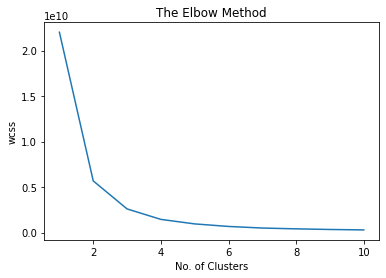

In [84]:
# Finding for the best k value
wcss = []
for i in range(1, 11):
  km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
  km.fit(df_ManhattanSeg4)
  wcss.append(km.inertia_)
  
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [85]:
# Run the KMeans algorithm with 5 clusters.
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 1 1 ... 2 1 0]


In [86]:
#Remove Dummie data
df_ManhattanSeg4["Clus_km"] = labels
df_ManhattanSeg4.head()

Dog_BirthYear  Dog_Gender_M  Breed_dum  Neighborhood_dum  Dog_NameDum  \
0           2011             1         49                 9          322   
1           2011             1         49                 9          322   
2           2011             1         49                 9          322   
4           2011             1         49                 9         1131   
5           2011             1         49                 9         1131   

   Clus_km  
0        1  
1        1  
2        1  
4        1  
5        1

In [87]:
df_ManhattanSeg4.shape

(11660, 6)

In [88]:
# this is the dataframe with categorical variable
df_segmentation7.head()

Dog_Name  Dog_BirthYear          Breed_Name    Borough      Neighborhood  \
0    BEANS           2011      Boston Terrier  Manhattan       East Harlem   
1    BEANS           2011      Boston Terrier  Manhattan       East Harlem   
2    BEANS           2011      Boston Terrier  Manhattan       East Harlem   
3    BEANS           2018  Labrador Retriever     Queens  Northwest Queens   
4     DEAN           2011      Boston Terrier  Manhattan       East Harlem   

   Dog_Gender_M  Breed_dum Borough_Dum  Neighborhood_dum  Dog_NameDum  
0             1         49           1                 9          322  
1             1         49           1                 9          322  
2             1         49           1                 9          322  
3             1        149           3                28          322  
4             1         49           1                 9         1131

In [89]:
#Filter "df_segmentation7" by Manhattan.
df_FilterM = df_segmentation7.drop(df_segmentation7[df_segmentation7['Borough']=='Brooklyn'].index)  
df_FilterM1 = df_FilterM.drop(df_FilterM[df_FilterM['Borough']=='Queens'].index)  
df_FilterM2 = df_FilterM1.drop(df_FilterM1[df_FilterM1['Borough']=='Bronx'].index) 
df_FilterM3 = df_FilterM2.drop(df_FilterM2[df_FilterM2['Borough']=='Staten Island'].index) 
df_FilterM3.shape

(11660, 10)

In [90]:
df_FilterM3.head()

Dog_Name  Dog_BirthYear      Breed_Name    Borough Neighborhood  \
0    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
1    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
2    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
4     DEAN           2011  Boston Terrier  Manhattan  East Harlem   
5     DEAN           2011  Boston Terrier  Manhattan  East Harlem   

   Dog_Gender_M  Breed_dum Borough_Dum  Neighborhood_dum  Dog_NameDum  
0             1         49           1                 9          322  
1             1         49           1                 9          322  
2             1         49           1                 9          322  
4             1         49           1                 9         1131  
5             1         49           1                 9         1131

In [91]:
df_FilterM3["Clus_km"] = labels
df_FilterM3.head()

Dog_Name  Dog_BirthYear      Breed_Name    Borough Neighborhood  \
0    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
1    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
2    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
4     DEAN           2011  Boston Terrier  Manhattan  East Harlem   
5     DEAN           2011  Boston Terrier  Manhattan  East Harlem   

   Dog_Gender_M  Breed_dum Borough_Dum  Neighborhood_dum  Dog_NameDum  Clus_km  
0             1         49           1                 9          322        1  
1             1         49           1                 9          322        1  
2             1         49           1                 9          322        1  
4             1         49           1                 9         1131        1  
5             1         49           1                 9         1131        1

In [92]:
df_FilterM3.shape

(11660, 11)

In [93]:
# Remove some columns.
df_FilterM4=df_FilterM3.drop(['Breed_dum','Borough_Dum','Neighborhood_dum','Dog_NameDum'],axis=1)
df_FilterM4.head()

Dog_Name  Dog_BirthYear      Breed_Name    Borough Neighborhood  \
0    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
1    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
2    BEANS           2011  Boston Terrier  Manhattan  East Harlem   
4     DEAN           2011  Boston Terrier  Manhattan  East Harlem   
5     DEAN           2011  Boston Terrier  Manhattan  East Harlem   

   Dog_Gender_M  Clus_km  
0             1        1  
1             1        1  
2             1        1  
4             1        1  
5             1        1

FileNotFoundError: [Errno 2] No such file or directory: 'Path where the CSV file is saved\\NY1_data.csv'

In [97]:
with open('NY1_data.json') as json_data:
    NY1_data = json.load(json_data)

FileNotFoundError: [Errno 2] No such file or directory: 'NY1_data.json'